# Validate

In [1]:
import os
import pickle
import json
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm

In [2]:
#
wd = os.getcwd()
wd_data = Path(os.path.join(wd, '__jsondata__'))
lst_data_json = list(wd_data.glob("*.json"))
lst_data_post = list(wd_data.glob("*.pkl"))
len(lst_data_json), len(lst_data_post)

(13, 13)

In [3]:
contests_data = {
	'contest_id' : [],
	'data_json' : [],
	'data_post' : []
}

for path_json, path_post in zip(lst_data_json, lst_data_post):
	contest_id = path_json.stem.split('_')[1]
	with open(path_json, "r", encoding="utf-8") as f:
		data_json = json.load(f)
	with open(path_post, "rb") as f:
		data_post = pickle.load(f)
	contests_data['contest_id'].append(int(contest_id))
	contests_data['data_json'].append(data_json)
	contests_data['data_post'].append(data_post)

print(contests_data['contest_id'])

[2467, 2762, 2549, 2860, 3928, 4493, 3507, 2435, 3526, 2478, 2454, 2445, 2464]


In [4]:
list(contests_data['data_json'][0].keys())

['theta',
 'percentage',
 'max_daily_submit',
 'ratio',
 'N_Delta',
 'Delta2f',
 'Ni',
 'Nj',
 'hat_t_i',
 'hat_t_j',
 'hat_y',
 'real_y']

In [5]:
list(contests_data['data_post'][0].keys())

['mu_0',
 'c_i',
 'c_j',
 'sigma',
 'lambda',
 'm_i',
 'm_j',
 'tilde_y',
 'intensity_i',
 'intensity_i_at_events',
 'intensity_j',
 'intensity_j_at_events',
 'effort_gap',
 'hat_y_mean',
 'hat_y_cov']

### Display Figure

In [6]:
#

### Display Statistics

In [7]:
def calculate_lambda_mle(arr_hat_y, arr_real_y, Delta2f):
	"""
	"""
	n = len(arr_hat_y)
	mse = sum([(hat_y - y)**2 for hat_y, y in zip(arr_hat_y, arr_real_y)])
	return n / mse / Delta2f

In [8]:
def display_estimation_results():
	data = []
	for id, json_data, posteriors in zip(
		contests_data['contest_id'], contests_data['data_json'], contests_data['data_post']
	):
		record = {
			'Id': id,
			'Ni': json_data['Ni'],
			'Nj': json_data['Nj'],
			'prize (k, USD)': json_data['theta'],
			'Percentage (%)': json_data['percentage'],
			'lambda_mle': calculate_lambda_mle(json_data['hat_y'], json_data['real_y'], json_data['Delta2f']),
			'lambda_post_mean': posteriors['lambda'].mean(),
			'sigma_post_mean': posteriors['sigma'].mean(),
		}
		data.append(record)
	return pd.DataFrame(data)

In [20]:
corss_contests = display_estimation_results()
corss_contests

,Id,Ni,Nj,"prize (k, USD)",Percentage (%),lambda_mle,lambda_post_mean,sigma_post_mean
0,2467,9,6,10.00,30.0,93.008188,7.203644,9.753148
1,2762,12,21,1.00,35.0,0.017897,0.100253,9.192004
2,2549,13,9,0.50,30.0,0.164106,0.197386,9.847563
3,2860,16,5,1.00,30.0,0.033051,0.426980,9.668195
4,3928,15,21,0.68,70.0,2.555218,7.237237,9.847612
5,4493,19,14,10.00,40.0,1.052005,3.646746,9.762965
6,3507,14,11,0.50,33.0,0.013709,0.006977,3.089605
7,2435,19,13,0.50,30.0,0.045923,0.182873,9.912726
8,3526,15,13,5.00,20.0,0.549113,0.143413,7.390572
9,2478,12,13,0.95,30.0,5.533020,0.350067,9.835965


In [26]:
log_lamb_hat_bayes = np.log(1 + corss_contests['lambda_post_mean'])
log_lamb_hat_real = np.log(1 + corss_contests['lambda_mle'])
X = sm.add_constant(log_lamb_hat_bayes)
model_lambda = sm.OLS(log_lamb_hat_real, X).fit()
log_lamb_hat_fit = model_lambda.predict(X)
model_lambda.summary()

/Users/zhuanglinsheng/Documents/Github/kaggle-contest-design/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lambda_mle   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     5.413
Date:                Wed, 21 May 2025   Prob (F-statistic):             0.0401
Time:                        17:53:23   Log-Likelihood:                -18.492
No. Observations:                  13   AIC:                             40.98
Df Residuals:                      11   BIC:                             42.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1562      0.394      0.396      0.700      -0.712       1.024
lambda_post_mean     0.8603      0.370      2.327      0.040       0.046       1.674
==============================================================================
Omnibus:                        7.531   Durbin-Watson:                   1.350
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                3.677
Skew:                           1.124   Prob(JB):                        0.159
Kurtosis:                       4.317   Cond. No.                         2.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

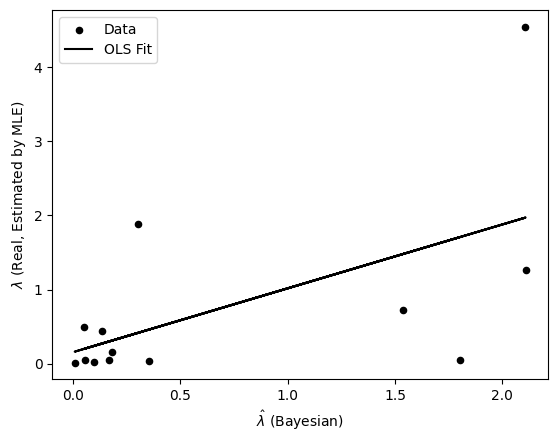

In [30]:
plt.scatter(log_lamb_hat_bayes, log_lamb_hat_real, s=20, label="Data", color="black", )
plt.plot(log_lamb_hat_bayes, log_lamb_hat_fit, label="OLS Fit", color="black")
plt.legend()
plt.xlabel(r"$\hat\lambda$ (Bayesian)")
plt.ylabel(r"$\lambda$ (Real, Estimated by MLE)")
plt.show()